# Introduction
In my [second post on HDB resale flat prices](https://dataandstuff.wordpress.com/2017/09/09/resale-flats-and-clusters/), I attempted to price resale flats in Jurong West by creating clusters of flats. The big idea behind this methodology was the realisation that it is impossible to explicitly account for all qualitative reasons why home buyers would want to buy a flat in a specific area. It could be because of good schools, proximity to amenities like transport centers and malls, or the liveliness of the areas. Furthermore, each factor would have different importance to different people. Modeling this would be a nightmare. Hence, I chose just two features to develop a spatial representation of these preferences: (1) latitude and (2) longitude. In fact, I showed that clusters of nearby flats shared a statistically meaningful relationship with resale prices in those clusters.  
  
In that post, I computed clusters for Jurong West. This time, I apply that methodology to all 26 towns in the dataset. The objective is to develop a set of clusters for **each town** to be used as categorical features in our model of HDB resale flat prices.

In [1]:
# Import modules
import gmaps
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn.apionly as sns
from scipy.spatial import ConvexHull
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import tabulate
import urllib.request as ur
import warnings

# Settings
%matplotlib inline
warnings.filterwarnings('ignore')

# Colours
def get_cols():
    
    print('[Colours]:')
    print('Orange:     #ff9966')
    print('Navy Blue:  #133056')
    print('Light Blue: #b1ceeb')
    print('Green:      #6fceb0')
    print('Red:        #f85b74')

    return

In [2]:
# Modify settings
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.grid.axis'] = 'y'
mpl.rcParams['grid.color'] = '#e8e8e8'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['xtick.color'] = '#494949'
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.color'] = '#494949'
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.edgecolor'] = '#494949'
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.labelpad'] = 15
mpl.rcParams['axes.labelcolor'] = '#494949'
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Raleway'
mpl.rcParams['scatter.marker'] = 'h'

# Colours
def get_cols():
    
    print('[Colours]:')
    print('Orange:     #ff9966')
    print('Navy Blue:  #133056')
    print('Light Blue: #b1ceeb')
    print('Green:      #6fceb0')
    print('Red:        #f85b74')

    return

# Geocoding
ArcGIS defines geocoding as "the process of transforming a description of a location—such as a pair of coordinates, an address, or a name of a place—to a location on the earth's surface". In the HDB resale flat dataset, we are provided with a block number and a street name. Combining these two features gives us an address that can be converted into latitude and longitude. If we think of latitude and longitude as the *y* and *x* axes on a graph, then each flat is simply a point on the graph, and groups of flats can be identified easily.  
  
How do we collect this data? Easy: we get it [HERE](https://developer.here.com/). HERE provides a host of location services like interactive maps, geocoding, traffic, tracking and routing. Its clients include Bing, Samsung, Audi, and Grab. Yes, Singapore's Grab. What's amazing is that it provides users with an API (see the link above) with up to **250,000 free requests**. That is an insanely large amount of requests, at least when compared to Google Places' 40,000 request limit.  
  
To begin, we load the HDB resale flat dataset and create two addresses:  
  
1. **Full Address:** To facilitating identification of the address. For example: *174 ANG MO KIO AVE 4*
2. **Search Address:** This is the address that we are going to append to our query to HERE. For example: *174+ANG+MO+KIO+AVE+4+SINGAPORE*
  
Note that I extracted the unique addresses from the full list of search addresses we created. This is to save time and stick within the query limit, because we need not geocode the same address more than once. 

In [3]:
# Read data
hdb = pd.read_csv('resale-flat-prices-based-on-registration-date-from-jan-2015-onwards.csv')

# Create addresses
hdb['full_address'] = hdb.block + ' ' + hdb.street_name
hdb['search_address'] = hdb.block + '+' + hdb.street_name.str.replace(' ', '+') + '+SINGAPORE'

# Extract search addresses
all_adds = hdb.search_address.unique()

Next, we need to configure two parameters: our individual app ID and app code. These can be found on your project page after you have created an account. We save these as variables:

In [4]:
# Set parameters
APP_ID = '[YOUR HERE APP ID]'
APP_CODE = '[YOUR HERE APP CODE]'

We will loop through the unique list of addresses, use `urllib` to query the API, `json` to process the JSON response (into a Python dictionary), and a custom function to extract the data we need from the processed response. The function `get_loc` retrieves two sets of latitude and longitude: the display position and the navigation position. Based on some testing, I discovered that the **average** of these two sets of coordinates was more accurate than either of them individually. Hence, I chose to compute the average latitude and average longitude.

In [5]:
# Define function to extract average location
# Takes a dictionary object
# Returns the average of display position and navigation position in a dictionary
def get_loc(result):
    
    # Output
    output = dict()
    
    if len(result['Response']['View']) > 0:
    
        # Get display position lat/long
        lat_dp = result['Response']['View'][0]['Result'][0]['Location']['DisplayPosition']['Latitude']
        lon_dp = result['Response']['View'][0]['Result'][0]['Location']['DisplayPosition']['Longitude']

        # Get navigation position lat/long
        lat_np = result['Response']['View'][0]['Result'][0]['Location']['NavigationPosition'][0]['Latitude']
        lon_np = result['Response']['View'][0]['Result'][0]['Location']['NavigationPosition'][0]['Longitude']
    
        # Configure output
        output['lat'] = (lat_dp + lat_np) / 2
        output['lon'] = (lon_dp + lon_np) / 2
        
    else:
        
        # Configure output
        output['lat'] = np.nan
        output['lon'] = np.nan
    
    return output

With the search addresses created, app ID and code configured, and the function defined, we are ready to geocode. Note that the output of `get_loc` for each search address was a dictionary, and all the dictionaries were saved into a list. This facilitated conversion into a Pandas dataframe. The code below will take approximately 5 minutes to run and 8.5k queries out of your HERE API limit. I've run the code and saved the results to a CSV file for quick loading.

In [6]:
# Initialise results
all_latlon = []

# Loop through to get lat lon
for i in range(len(all_adds)):
    
    # Extract address
    temp_add = all_adds[i]
    
    # Configure URL
    temp_url = 'https://geocoder.api.here.com/6.2/geocode.json' + \
      '?app_id=' + APP_ID + \
      '&app_code=' + APP_CODE + \
      '&searchtext=' + temp_add
    
    # Pull data
    temp_response = ur.urlopen(ur.Request(temp_url)).read()
    temp_result = json.loads(temp_response)
    
    # Process data
    temp_latlon = get_loc(temp_result)
    
    # Add address
    temp_latlon['address'] = temp_add
    
    # Append
    all_latlon.append(temp_latlon)
    
    # Update
    print(str(i) + '. ', 'Getting data for: ' + str(temp_add))

# Convert to data frame
full_latlon = pd.DataFrame(all_latlon)

# Save
full_latlon.to_csv('latlon_data.csv', index = False)

Here's a preview of the data:

In [7]:
# Load data
map_latlon = pd.read_csv('latlon_data.csv')

# View
map_latlon.head()

address       lat         lon
0   174+ANG+MO+KIO+AVE+4+SINGAPORE  1.375270  103.837640
1  541+ANG+MO+KIO+AVE+10+SINGAPORE  1.374025  103.855695
2   163+ANG+MO+KIO+AVE+4+SINGAPORE  1.373885  103.838110
3  446+ANG+MO+KIO+AVE+10+SINGAPORE  1.367855  103.855395
4  557+ANG+MO+KIO+AVE+10+SINGAPORE  1.371540  103.857790

We will use this data frame to map the search addresses in the main dataframe to a latitude and longitude pair. With that, we are done with geocoding.

In [8]:
# Set index - I should have named the search address as search_address in the loop
map_latlon = map_latlon.rename({'address': 'search_address'})
map_latlon = map_latlon.set_index('address')

# Separate maps
map_lat = map_latlon['lat']
map_lon = map_latlon['lon']

# Map
hdb['lat'] = hdb.search_address.map(map_lat)
hdb['lon'] = hdb.search_address.map(map_lon)

# Clustering
Next, we develop clusters within each of the 26 towns using the resale flats' coordinates. Let's use Jurong West as an example.

## Jurong West
First, we extract the coordinates of flats in Jurong West and scale the coordinates using the `MinMaxScaler`. This transforms each of the coordinates into features that range between 0 and 1 to ensure that longitude, which has a larger magnitude (100 vs. 1), does not affect the distance calculations in clustering.

In [9]:
# For Jurong West
dat_jw = hdb[['lat', 'lon']][hdb.town == 'JURONG WEST']
dat_jw = dat_jw.reset_index(drop = True)

# Normalise
mmscale = MinMaxScaler()
mmscale.fit(dat_jw)
dat_jw_scaled = pd.DataFrame(mmscale.transform(dat_jw), columns = ['lat', 'lon'])
dat_jw_scaled.head()

lat       lon
0  0.685821  0.624126
1  0.703477  0.616068
2  0.758060  0.652565
3  0.685821  0.624126
4  0.824356  0.927597

Next, we apply K-Means clustering on the dataset. Testing out different values of *k* (2 to 22) and using the elbow method to decide on an optimal *k*, we get *k* = 7.

In [10]:
# Set up values of k
all_k = np.arange(2, 23, 1)

# Initialise results
k_results = []

# Loop through values of k
for k in all_k:
    
    # Set up kmeans
    km1 = KMeans(n_clusters = k, random_state = 123)

    # Fit data
    km1.fit(dat_jw_scaled)

    # Score data
    k_results.append(km1.inertia_)

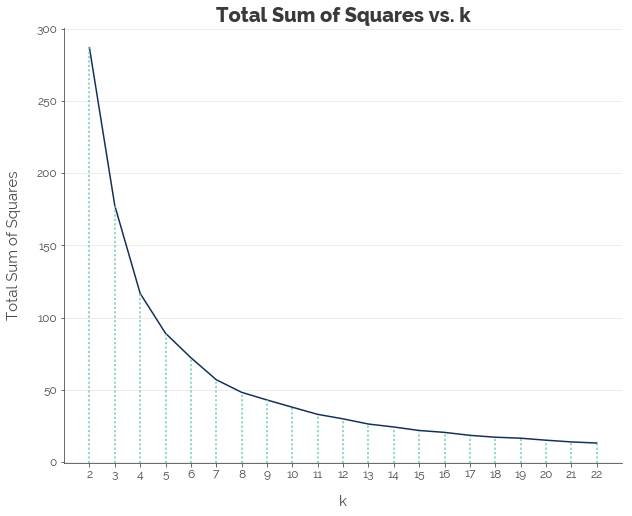

In [11]:
# CODE FOR CUSTOM GRAPHICS NOT INCLUDED

Hence, we fit a K-Means model with *k* = 7 and assign each resale flat to a cluster.

In [12]:
# Fitting 7 clusters:
km_final = KMeans(n_clusters = 7, random_state = 123)
km_final.fit(dat_jw_scaled)
dat_jw['label'] = km_final.labels_

We find some differentiation in resale prices across the clusters. For example, Jurong West Cluster 3 contains flats that are generally more expensive than Clusters 1, 2, 5, and 6.

In [13]:
dat_jw_full = hdb[hdb.town == 'JURONG WEST']
dat_jw_full['label'] = km_final.labels_ + 1

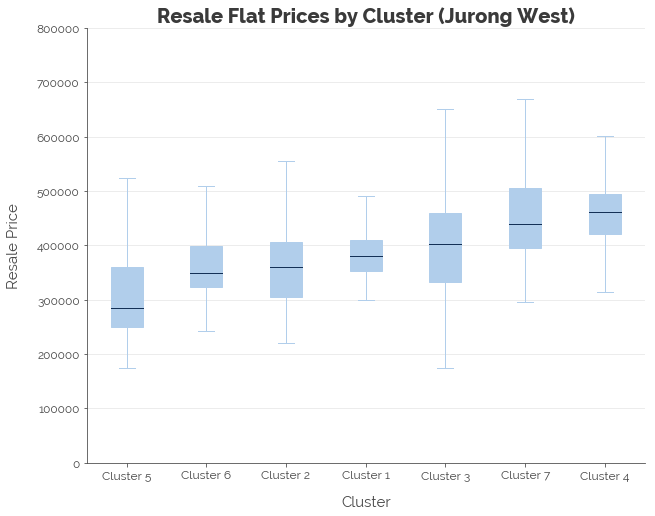

In [14]:
# CODE FOR CUSTOM GRAPHICS NOT INCLUDED

Even though the clustering looks good statistically, it always makes sense to do a visual check, which can be done using the `gmaps` module. `gmaps` uses the Google Maps Javascript API (Google provides a free API key) to generate a HTML Google Map. We plot the **unique** coordinates of flats, color-coded by label, to give us a map with 7 distinct zones. The map shows that 7 clusters is a good fit (or at least isn't terrible).

In [15]:
# GMAPS
GOOGLE_API = '[YOUR GOOGLE API KEY HERE]'
gmaps.configure(api_key = GOOGLE_API)

# Configure labels and column names
dat_jw_plot = dat_jw[['lat', 'lon', 'label']].copy()
dat_jw_plot['label'] = dat_jw_plot['label'] + 1
dat_jw_plot = dat_jw_plot.rename(columns = {'lat': 'latitude', 'lon': 'longitude'})

# Remove duplicates
dat_jw_plot = dat_jw_plot.drop_duplicates()
latlon_jw = dat_jw_plot[['latitude', 'longitude']]

# Create layers
# Colour code:
#  - 1: Blue
#  - 2: Orange
#  - 3: Green
#  - 4: Red
#  - 5: Purple
#  - 6: Brown
#  - 7: Pink
#  - 8: Grey
c1 = gmaps.symbol_layer(latlon_jw[dat_jw_plot.label == 1], fill_color = '#1f77b4', stroke_color='#1f77b4', scale = 2)
c2 = gmaps.symbol_layer(latlon_jw[dat_jw_plot.label == 2], fill_color = '#ff7f0e', stroke_color='#ff7f0e', scale = 2) 
c3 = gmaps.symbol_layer(latlon_jw[dat_jw_plot.label == 3], fill_color = '#2ca02c', stroke_color='#2ca02c', scale = 2)
c4 = gmaps.symbol_layer(latlon_jw[dat_jw_plot.label == 4], fill_color = '#d62728', stroke_color='#d62728', scale = 2)
c5 = gmaps.symbol_layer(latlon_jw[dat_jw_plot.label == 5], fill_color = '#9467bd', stroke_color='#9467bd', scale = 2)
c6 = gmaps.symbol_layer(latlon_jw[dat_jw_plot.label == 6], fill_color = '#8c564b', stroke_color='#8c564b', scale = 2)
c7 = gmaps.symbol_layer(latlon_jw[dat_jw_plot.label == 7], fill_color = '#e377c2', stroke_color='#e377c2', scale = 2)

# Create base map
t1 = gmaps.figure()

# Add layers
t1.add_layer(c1)
t1.add_layer(c2)
t1.add_layer(c3)
t1.add_layer(c4)
t1.add_layer(c5)
t1.add_layer(c6)
t1.add_layer(c7)

# Visualise
t1

Figure(layout=FigureLayout(height='420px'))

## Function to Plot Elbow Graph

In [16]:
def clust_town(town):
    # Extract town data
    temp_dat = hdb[['lat', 'lon']][hdb.town == town]
    temp_dat = temp_dat.reset_index(drop = True)

    # Normalise
    temp_mm = MinMaxScaler()
    temp_mm.fit(temp_dat)
    temp_dat_scaled = pd.DataFrame(temp_mm.transform(temp_dat), columns = ['lat', 'lon'])

    # Set up values of k
    temp_k = np.arange(2, 23, 1)

    # Initialise results
    temp_results = []

    # Loop through values of k
    for k in temp_k:

        # Set up kmeans
        temp_km = KMeans(n_clusters = k, random_state = 123)

        # Fit data
        temp_km.fit(temp_dat_scaled)

        # Score data
        temp_results.append(temp_km.inertia_)

    # Plot
    plt.plot(temp_k, temp_results)
    plt.title(town)
    plt.show()
    

In [17]:
# NOT RUN
# Perform clustering on each town using k = 2 to 22 to choose an optimal k
# for t in hdb.town.value_counts().index:
    
#     clust_town(t)

## Function to Plot Maps

In [18]:
def clust_map(town):
    
    # Extract town data
    temp_dat = hdb[['lat', 'lon']][hdb.town == town]
    temp_dat = temp_dat.reset_index(drop = True)
    
    # Normalise
    temp_mm = MinMaxScaler()
    temp_mm.fit(temp_dat)
    temp_dat_scaled = pd.DataFrame(temp_mm.transform(temp_dat), columns = ['lat', 'lon'])
    
    # Get optimal clusters
    opt_clust = disp_clust.loc[town][0]
    
    # Fitting 7 clusters:
    temp_km = KMeans(n_clusters = opt_clust, random_state = 123)
    temp_km.fit(temp_dat_scaled)
    
    # Configure labels and column names
    plot_labels = temp_dat[['lat', 'lon']].copy()
    plot_labels['label'] = temp_km.labels_ + 1
    plot_labels = plot_labels.rename(columns = {'lat': 'latitude', 'lon': 'longitude'})

    # Remove duplicates
    plot_labels = plot_labels.drop_duplicates()
    plotdata = plot_labels[['latitude', 'longitude']]
    
    # Configure colours
    temp_colors = sns.color_palette().as_hex()
    
    # Create base graph
    out_graph = gmaps.figure()
    
    # Add layers sequentially
    for i in range(opt_clust):
        
        # Add layer
        out_graph.add_layer(
            gmaps.symbol_layer(
                plotdata[plot_labels.label == i + 1],
                fill_color = temp_colors[i], stroke_color = temp_colors[i],
                scale = 2
            )
        )
    
    # Output
    return out_graph

# Function to plot all points
def clust_map_all(town):
    
    # Extract town data
    temp_dat = hdb[['lat', 'lon']][hdb.town == town]
    temp_dat = temp_dat.reset_index(drop = True)
    
    # Remove duplicates
    temp_dat = temp_dat.drop_duplicates()
    
    # Create base graph
    out_graph = gmaps.figure()
    
    # Add layer
    out_graph.add_layer(gmaps.symbol_layer(temp_dat, scale = 2))
    
    # Output
    return out_graph

In [19]:
# NOT RUN
# Run clust_map for all towns to check that the k values make sense
# clust_map('[TOWN HERE]')

In [20]:
# Decide on clusters
clust_results = [7, 5, 6, 7, 7, 4, 5, 6, 5, 5, 3, 6, 5, 7, 7, 6, 6, 5, 5, 8, 5, 5, 4, 2, 1, 2]

# Create dataframe
disp_clust = pd.DataFrame(
    [hdb.town.value_counts().index, clust_results], index = ['Town', 'Clusters']
).T.set_index('Town')

# Create markdown table
# print(tabulate.tabulate(disp_clust, tablefmt="pipe", headers = 'keys'))

## Calculate Optimal Clusters for All Towns
Performing the same process of selecting an optimal *k* using the elbow and graphical methods, we obtained the following results:  
  
| Town            |   Clusters |
|:----------------|-----------:|
| JURONG WEST     |          7 |
| SENGKANG        |          5 |
| WOODLANDS       |          6 |
| TAMPINES        |          7 |
| BEDOK           |          7 |
| YISHUN          |          4 |
| PUNGGOL         |          5 |
| HOUGANG         |          6 |
| ANG MO KIO      |          5 |
| CHOA CHU KANG   |          5 |
| BUKIT BATOK     |          3 |
| BUKIT MERAH     |          6 |
| BUKIT PANJANG   |          5 |
| TOA PAYOH       |          7 |
| KALLANG/WHAMPOA |          7 |
| PASIR RIS       |          6 |
| SEMBAWANG       |          6 |
| GEYLANG         |          5 |
| QUEENSTOWN      |          5 |
| CLEMENTI        |          8 |
| JURONG EAST     |          5 |
| SERANGOON       |          5 |
| BISHAN          |          4 |
| CENTRAL AREA    |          2 |
| MARINE PARADE   |          1 |
| BUKIT TIMAH     |          2 |
  

## Attach Clusters to Dataset
To obtain the cluster labels for each town, we fit a K-Means model to the scaled data and the optimal *k* value for each town. This generates labels, which we then attach to the original dataset, town by town, under the feature `label`. To distinguish between the clusters of different towns, we generate a new feature `cluster` that appends the town name to the cluster label. That gives us a total of 134 clusters across Singapore.

In [21]:
# Get list of towns
all_towns = hdb.town.value_counts().index

# Initialise label
hdb['label'] = 0

# Loop through
for town in all_towns:
    
    # Extract town data
    temp_dat = hdb[['lat', 'lon']][hdb.town == town]
    temp_dat = temp_dat.reset_index(drop = True)

    # Normalise
    temp_mm = MinMaxScaler()
    temp_mm.fit(temp_dat)
    temp_dat_scaled = pd.DataFrame(temp_mm.transform(temp_dat), columns = ['lat', 'lon'])
    
    # Get optimal clusters
    opt_clust = disp_clust.loc[town][0]
    
    # Fit optimal clusters:
    temp_km = KMeans(n_clusters = opt_clust, random_state = 123)
    temp_km.fit(temp_dat_scaled)
    
    # Attach labels
    hdb['label'][hdb.town == town] = temp_km.labels_ + 1

# Attach town name to cluster label
hdb['clust'] = hdb.town + '_' + hdb.label.astype('str')

Here's the full map of all clusters in Singapore:

In [22]:
# Extract town data
full_dat = hdb[['lat', 'lon', 'clust', 'town']]
full_dat = full_dat.reset_index(drop = True)

# Remove duplicates
full_dat = full_dat.drop_duplicates()

# Rename columns
full_dat = full_dat.rename(columns = {'lat': 'latitude', 'lon': 'longitude'})

# Sort
full_dat = full_dat.sort_values(['longitude', 'latitude'])

# Extract towns
all_towns = list(full_dat.town.unique())

# Extract cluster names
all_clust = list(full_dat.clust.unique())

# Configure colours
all_colors = sns.color_palette().as_hex()

# Configure town colors
town_colors = all_colors * 3

In [23]:
# Create base graph
out_graph = gmaps.figure()

# Loop through clusters
for t in range(len(all_towns)):
    
    # Get clusters
    temp_clust = full_dat.clust[full_dat.town == all_towns[t]].unique()
    
    # Town coordinates
    temp_towndata = full_dat[['latitude', 'longitude']][full_dat.town == all_towns[t]].copy()
    
    # Get town coords
    temp_towncoords = np.array([[n, m] for n, m in zip(temp_towndata.longitude, temp_towndata.latitude)])
    
    # Calculate convex hull
    temp_townhull = ConvexHull(temp_towncoords)
    
    # Drawing
    temp_towndrawing = gmaps.drawing_layer(features=[
         gmaps.Polygon(
             [(n, m) for n, m in zip(temp_towncoords[temp_townhull.vertices, 1], temp_towncoords[temp_townhull.vertices, 0])],
             fill_color = town_colors[t], fill_opacity = 0.3, stroke_color = 'black'
         )
    ], show_controls = False)

    # Add drawing
    out_graph.add_layer(temp_towndrawing)
    
    # Get town center
    
    # Add point
    out_graph.add_layer(
        gmaps.symbol_layer(
            [(temp_towndata.latitude.median(), temp_towndata.longitude.median())],
            fill_color = town_colors[t], stroke_color = town_colors[t],
            scale = 1
        )
    )
    
    for c in range(len(temp_clust)):

        # Extract coordinates
        temp_plotdata = full_dat[['latitude', 'longitude']][full_dat.clust == temp_clust[c]].copy()

        # Get coords
        temp_coords = np.array([[x, y] for x, y in zip(temp_plotdata.longitude, temp_plotdata.latitude)])

        # Calculate convex hull
        temp_hull = ConvexHull(temp_coords)

        # Drawing
        temp_drawing = gmaps.drawing_layer(features=[
             gmaps.Polygon(
                 [(x, y) for x, y in zip(temp_coords[temp_hull.vertices, 1], temp_coords[temp_hull.vertices, 0])],
                 fill_color = all_colors[c], fill_opacity = 0.3, stroke_color = all_colors[c]
             )
        ], show_controls = False)

        # Add drawing
        out_graph.add_layer(temp_drawing)

In [24]:
out_graph

Figure(layout=FigureLayout(height='420px'))

# Conclusion
In this post, I demonstrated how an address created from block numbers and streets in the HDB resale flat dataset could be used to generate new features. Geocoding was used to convert addresses into geographic coordinates, and coordinates were used to generate clusters within each town. This produced a total of 134 clusters across Singapore. Hopefully, these will be useful when we develop our machine learning model to predict resale flat prices.